# MAST-ML Workflow Activity


---
This activity serves as an introduction to the more pythonic way of working with the MAST-ML software. During the activity we'll see how to set up some basic MAST-ML workflows which mirror workflows previously explored via:
- Citrination
- Nanohub Introduction to Machine Learning for Materials Science

Throughout the instructions we'll reference directly back to the Nanohub notebook. I'ld advise you have that open in a second tab to refer back to. you can find that notebook here:  
www.nanohub.org/tools/intromllab

The overall goal is to reproduce those workflows using the MAST-ML software, learn how to execute calls to MAST-ML, and how to find and anlyze the results.

This notebook is setup in a linear fashion where working from top to bottom will execute the full workflow.


## Section 1: Setting up our Google Colab Environment
---
Before running any code we first need to install MAST-ML as well as it's dependencies into the colab environment.


In [1]:
# !pip install mastml

**Reminder, make sure to go to runtime at the top of the page and select "restart session" before continuing. After restarting the session you can skip the pip install command and proceed to the import and drive sync.**

Now we'll sync Colab with our google drive so that we can save directly our outputs to google drive. If you haven't already I recommend making a folder in google drive titled "MASTML_colab" or something similar to direct all your results towards. Going forward I'll assume this folder exists and I'll base the runs out of that folder. If you want to change the naming that can work as well as long as you update when that location is referenced.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Here we import the MAST-ML modules used. Note that if you're making edits you may have to come back to update these imports to grab new functionality that isn't included here.

In [3]:
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.data_cleaning import DataCleaning
from mastml.preprocessing import SklearnPreprocessor
from mastml.models import SklearnModel
from mastml.data_splitters import SklearnDataSplitter, NoSplit
from mastml.feature_selectors import EnsembleModelFeatureSelector, NoSelect
from mastml.feature_generators import ElementalFeatureGenerator
from mastml.hyper_opt import GridSearch

Figshare is an optional dependency. To import data from figshare, manually install figshare via git clone of git clone https://github.com/cognoma/figshare.git
linear-tree is an optional dependency, enabling use of Linear tree, forest, and boosting models. If you want to use this model, do "pip install linear-tree"


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Program Files\Python311\Lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Program Files\Python311\Lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


And finally we'll import pandas to help with handling dataframes throughout the notebook.

In [4]:
import pandas as pd

## Section 2: Data Cleaning


---
this section is largely the same as the previous notebook in functionality.
We'll read in the same initial bandgap data we used in the previous notebook then perform the same cleaning steps:  
1) Filtering for "Reliability"  
2) Averaging bandgap values where we have duplicates  


Read in the band gap data from our dataset. If you haven't already upload the bandgap_data_v2.csv data to the MASTML_colab folder.

If you uploaded previously to the default folder on colab you can now drag the .csv file into the MASTML_colab folder under /drive/MyDrive/MASTML_colab/

In [5]:
mastml_df = pd.read_csv("bandgap_data_v2.csv")
mastml_df

,index,chemicalFormula Clean,Band gap values Clean,Band gap units,Band gap method,Reliability
0,0,Li1F1,13.60,eV,Reflection,1
1,1,Li1F1,12.61,eV,Reflection,1
2,2,Li1F1,12.60,eV,Estimated,2
3,3,Li1F1,12.10,eV,Absorption,2
4,4,Li1F1,12.00,eV,Absorption,2
...,...,...,...,...,...,...
1442,1454,Th1O2,3.30,eV,Reflection,2
1443,1455,UO,1.50,eV,Thermal activation,1
1444,1456,U1O2,2.18,eV,Absorption,1
1445,1457,UO,0.60,eV,Thermal activation,2


Filter for only Reliability 1. This is the same python call used in the previous notebook.

In [6]:
mastml_df_filtered = mastml_df[mastml_df["Reliability"]==1]
mastml_df_filtered

,index,chemicalFormula Clean,Band gap values Clean,Band gap units,Band gap method,Reliability
0,0,Li1F1,13.600,eV,Reflection,1
1,1,Li1F1,12.610,eV,Reflection,1
6,6,Li1Cl1,9.330,eV,Reflection,1
7,7,Li1Br1,7.950,eV,Absorption,1
9,9,Li3Sb1,1.000,eV,Thermal activation,1
...,...,...,...,...,...,...
1433,1445,Bi,0.015,eV,Magnetoreflection,1
1436,1448,Th1O2,5.750,eV,NaN,1
1437,1449,Th1O2,3.500,eV,Absorption,1
1443,1455,UO,1.500,eV,Thermal activation,1


Note that for these steps we're not using MASTML because these are very custom steps to this dataset that aren't generic data cleaning steps included in MASTML.

We then do the same bandgap averaging when we have duplicates in the dataset.

In [7]:
mastml_df_clean = mastml_df_filtered.groupby("chemicalFormula Clean", as_index = False).mean(numeric_only=True)
mastml_df_clean

,chemicalFormula Clean,index,Band gap values Clean,Reliability
0,Ag1Br1,808.5,3.485,1.0
1,Ag1Cl1,793.5,4.190,1.0
2,Ag1N3,783.0,3.900,1.0
3,Ag1Te1,820.0,0.850,1.0
4,Ag2O1,785.0,1.200,1.0
...,...,...,...,...
462,Zr1Se2,739.0,2.000,1.0
463,Zr1Se3,740.0,1.250,1.0
464,Zr3O1,730.0,0.200,1.0
465,Zr6O1,729.0,0.180,1.0


This section is new. We reset the index to match the previous notebook so that we can explicitly define the same Train / Test split that we used before. The test_indices object is just a hard copied list of the index values from the previous notebook. If you want to go check them you can find the X_test object and call X_test.index to see these yourself.

In [8]:
mastml_df_clean.reset_index(inplace=True)
mastml_df_clean.drop(columns='level_0',inplace=True)
mastml_df_clean

,chemicalFormula Clean,index,Band gap values Clean,Reliability
0,Ag1Br1,808.5,3.485,1.0
1,Ag1Cl1,793.5,4.190,1.0
2,Ag1N3,783.0,3.900,1.0
3,Ag1Te1,820.0,0.850,1.0
4,Ag2O1,785.0,1.200,1.0
...,...,...,...,...
462,Zr1Se2,739.0,2.000,1.0
463,Zr1Se3,740.0,1.250,1.0
464,Zr3O1,730.0,0.200,1.0
465,Zr6O1,729.0,0.180,1.0


In [9]:
test_indices = [279, 168, 192,  33, 223,  22, 341, 453, 460, 455, 120, 430, 436,
            366, 292, 278, 163, 216, 420, 210, 214, 422, 340,  41, 416, 146,
            280, 229, 300, 111, 407, 250, 379,  20, 356,   4, 141, 139, 121,
            324, 147, 415,  57, 301, 393, 454,  30]

Finally we define a new column "testdata" which is going to be a binary column that is either 0 for "not testing data" or 1 for "is testing data". This is what we can feed into MAST-ML to explicitly define a set of Test data that is held out from all training.

In [10]:
mastml_df_clean["testdata"]=0

In [11]:
for idx in test_indices:
  mastml_df_clean.at[idx,'testdata']=1

And with that setup we'll save a new version of the dataset just to keep track of changes as we go.

In [12]:
output_path = "bandgap_data_v3.csv"
mastml_df_clean.to_csv(output_path,index=False)

In [13]:
mastml_df_clean

,chemicalFormula Clean,index,Band gap values Clean,Reliability,testdata
0,Ag1Br1,808.5,3.485,1.0,0
1,Ag1Cl1,793.5,4.190,1.0,0
2,Ag1N3,783.0,3.900,1.0,0
3,Ag1Te1,820.0,0.850,1.0,0
4,Ag2O1,785.0,1.200,1.0,1
...,...,...,...,...,...
462,Zr1Se2,739.0,2.000,1.0,0
463,Zr1Se3,740.0,1.250,1.0,0
464,Zr3O1,730.0,0.200,1.0,0
465,Zr6O1,729.0,0.180,1.0,0


Notice how in the initial data cleaning and configuration there is still a bit that we do outside of MAST-ML. While MAST-ML gives a good deal of flexibility and useful tools for performing these machine learning workflows there will often still be custom steps like this that get added to the overall workflow that varies dataset by dataset.

## Section 3: Initializing MAST-ML
---
Now we'll dive into interacting more directly with the MAST-ML software. The first thing we need to do is setup some of the baseline information that MASTML will use as we call different sections of the code. This is similar to the [general] section from the previous configuration file oriented code base.


Set the name of the savepath to save MAST-ML results to. It's recommended to make this a unique name each time you come back to this notebook. That way all the outputs you get from each session will be in a unique location that's easier to come back to later.

By default I've set the output to the "nanohub_workflow" folder under our colab folder.

In [14]:
SAVEPATH = 'Nanohub_workflow'

mastml = Mastml(savepath=SAVEPATH)
savepath = mastml.get_savepath

With MAST-ML initialized you should see your output directory created. You can check this using the file tree on the left of the screen or directly through google drive.

Next up we need to define the configuration of our Data file that we setup earlier. We'll define the names for all of the key components:  
target: the target variable that we want to predict  
extra_columns: the metadata columns that aren't features but we still want to keep track off  
testdata_columns: the column with binary values defining what is and isn't test data  
group_column: column names specifying unique groups in the data. We don't use this during this workflow  
as_frame: determines the structure of outputs. True gives us dataframe outputs that are easier to read in the notebook

In [15]:
target = 'Band gap values Clean'
extra_columns = ['index', 'Reliability','chemicalFormula Clean']
testdata_columns = ['testdata']

# calling the LocalDatasets section of the code initializes this section which we then execute with the method below
d = LocalDatasets(file_path='bandgap_data_v3.csv',
                  target=target,
                  extra_columns=extra_columns,
                  group_column=None,
                  testdata_columns=testdata_columns,
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

In [16]:
data_dict

{'X': Empty DataFrame
 Columns: []
 Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
 
 [467 rows x 0 columns],
 'y': 0      3.485
 1      4.190
 2      3.900
 3      0.850
 4      1.200
        ...  
 462    2.000
 463    1.250
 464    0.200
 465    0.180
 466    0.600
 Name: Band gap values Clean, Length: 467, dtype: float64,
 'groups': None,
 'X_extra':      index  Reliability chemicalFormula Clean
 0    808.5          1.0                Ag1Br1
 1    793.5          1.0                Ag1Cl1
 2    783.0          1.0                 Ag1N3
 3    820.0          1.0                Ag1Te1
 4    785.0          1.0                 Ag2O1
 ..   

Let's take a second to look through what just happened. In the previous cell the "data_dict" object was defined. It is a dictionary of various things that were loaded in from the dataseet. We'll pull those out of the dictionary to set them all to unique objects.

We see there are 5 keys:  
  X: the X feature matrix (used to fit the ML model). notice this is empty becausee we haven't done any feature generation  
  y: the y target data vector (true values)  
  X_extra: matrix of meta data not used in fitting (i.e. not part of X or y)  
  groups: vector of group labels. empty because we didn't set it  
  X_testdata: matrix or vector of left out data indices

In [17]:
data_dict.keys()

dict_keys(['X', 'y', 'groups', 'X_extra', 'X_testdata'])

We'll take each of these and assign them to their own object, to use going forwards.

In [18]:
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']
groups = data_dict['groups']
X_testdata = data_dict['X_testdata']

In [19]:
X

""
0
1
2
3
4
...
462
463
464
465


In [20]:
groups

In [21]:
X_extra

,index,Reliability,chemicalFormula Clean
0,808.5,1.0,Ag1Br1
1,793.5,1.0,Ag1Cl1
2,783.0,1.0,Ag1N3
3,820.0,1.0,Ag1Te1
4,785.0,1.0,Ag2O1
...,...,...,...
462,739.0,1.0,Zr1Se2
463,740.0,1.0,Zr1Se3
464,730.0,1.0,Zr3O1
465,729.0,1.0,Zr6O1


In [22]:
X_testdata

[array([  4,  20,  22,  30,  33,  41,  57, 111, 120, 121, 139, 141, 146,
        147, 163, 168, 192, 210, 214, 216, 223, 229, 250, 278, 279, 280,
        292, 300, 301, 324, 340, 341, 356, 366, 379, 393, 407, 415, 416,
        420, 422, 430, 436, 453, 454, 455, 460], dtype=int64)]

## Section 4: Reproducing Key Workflow Steps
---
Now we'll start to dive into reproducing the key workflow steps from the previous notebook. These are:  
1) Feature Generation  
2) Feature Engineering  
3) Model Assessment and Training  
4) Model Optimization  
5) Model Predictions

If the data contains missing values (this one doesn't), we can clean the data with the built in tools in MAST-ML, which corrects missing values and provides some basic analysis of the input data. Since there are no missing values the data cleaner will still output some useful plots and statistics of our input data.

In [23]:
cleaner = DataCleaning()
X, y = cleaner.evaluate(X=X,
                        y=y,
                        method='imputation',
                        strategy='mean',
                        savepath=savepath)

Looking at the format of the DataCleaning section also highlights the key way we will interact with MAST-ML in this format. For each section of the code we want to use we'll initialize it using what's called a class name, in this case "DataCleaning", and then call the "evaluate" method to essentially run the code for that Class.

Let's look through the outputs and compare them to some of the initial dataset analysis and compare to the previous Nanohub workflow. Open the "histogram_target_values.png" file in the newly created DataCleaning folder under our output directory. Compare back to the histogram we made in the previous notebook. Are they the same?

This is the type of check we would do to make sure we aren't missing any data switching between the two platforms.

Next is generating the elemental features used in the model. Just like the previous step we define the class of feature generation we want to use, and then call the evaluate method. Again results are output to a new folder with the name of the Class that was evaluated. The features are also added to the X object so we can continue to use them directly without having to read in from the generated files.

You can see from the output that MAST-ML is also performing some basic feature engineering by dropping features that are missing values. This is the most basic way of handling missing values, and if we wanted to do something more complex later we could come back and use imputation to fill in those missing values instead.

In [24]:
generator = ElementalFeatureGenerator(featurize_df = X_extra["chemicalFormula Clean"],
                      feature_types='composition_avg',
                      remove_constant_columns=True)
X, y = generator.evaluate(X = X,
                          y = y,
                          savepath = savepath)

Featurizing compositions:: 467it [00:16, 27.57it/s]


Dropping 1/88 generated columns due to missing values


Using the cell block below with outputs the feature object directly compare the features generated to those in the previous workflow. Do we have the same total number?

If they're different can you think of any reasons why?  
hint: mastml does some initial cleaning automatically on the features.

In [25]:
X

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,AtomicWeight_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,...,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,SpecificHeatCapacity_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,phi_composition_average,valence_composition_average
0,41.000000,1.292000,29.801737,93.886100,6.899312,-1.859305,3.029987,0.0,20.880000,-2.025000,...,21.645000,15.000000,144.50,0.230500,214.561000,9.450000,35.415000,0.680000,2.175000,4.500000
1,32.000000,1.217000,9167.291343,71.660600,6.638434,-1.837262,3.132737,0.0,18.370000,-2.043750,...,22.650000,15.000000,144.50,0.357500,214.504450,9.450000,37.220500,0.680000,2.175000,4.500000
2,17.000000,1.051000,13948.643137,37.472075,5.205755,-3.722883,5.719423,0.0,9.285000,-5.874062,...,27.573250,7.500000,201.75,0.840250,107.269485,184.725000,44.293500,1.577500,6.232500,4.250000
3,49.500000,1.522000,25.516168,117.734100,7.027453,-2.777049,6.005337,0.0,22.250000,-3.296667,...,20.045000,23.000000,188.50,0.218500,215.675000,18.850000,31.395000,0.680000,2.175000,4.000000
4,34.000000,1.206000,6208.782821,77.245267,5.882258,-2.633237,3.726351,0.0,13.243333,-0.678333,...,26.032333,20.000000,154.00,0.463333,286.089133,272.600000,41.531333,0.906667,2.900000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,36.000000,1.466667,25.894518,83.048000,6.952832,-4.756252,5.150524,0.0,21.030000,-3.981667,...,18.503333,13.466667,74.00,0.306000,8.926667,31.900000,28.210000,0.470000,1.150000,5.333333
463,35.500000,1.450000,26.223089,82.026000,6.929431,-4.292375,5.265833,0.0,20.815000,-4.423750,...,19.175000,11.025000,59.00,0.309500,7.205000,35.175000,28.862500,0.352500,0.862500,5.500000
464,32.000000,1.382500,4665.498749,72.417850,6.578746,-6.965394,3.939421,0.0,18.895000,-0.777500,...,18.626750,24.750000,148.50,0.438500,17.091850,199.275000,30.976000,1.057500,2.587500,3.500000
465,35.428571,1.475714,2675.970404,80.477629,6.819299,-7.609057,4.063120,0.0,20.547143,-0.635000,...,16.271000,28.285714,168.00,0.369714,19.495343,116.314286,27.553429,1.208571,2.957143,3.714286


Next we'll see one of the benefits of using MAST-ML in this new way. Currently we don't have the same method impelemented in MAST-ML to remove highly correlated features. Previously adding this in would have been a good deal of work. But because we're using MAST-ML in this interactive notebook environment we can add in our own feature engineering steps that aren't included in the MAST-ML software. Below I just copied over the code from the previous notebook to filter highly correlated features

In [26]:
import numpy as np

In [27]:
features_corr_df = X.corr(method="pearson").abs()
# Filter the features with correlation coefficients above 0.95
upper = features_corr_df.where(np.triu(np.ones(features_corr_df.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X = X.drop(columns=to_drop)

In [28]:
X

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,BoilingT_composition_average,...,NsValence_composition_average,Polarizability_composition_average,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,valence_composition_average
0,41.000000,1.292000,29.801737,6.899312,-1.859305,3.029987,0.0,20.880000,-2.025000,1383.500000,...,1.500000,5.020000,21.645000,15.000000,144.50,214.561000,9.450000,35.415000,0.680000,4.500000
1,32.000000,1.217000,9167.291343,6.638434,-1.837262,3.132737,0.0,18.370000,-2.043750,1336.980000,...,1.500000,4.585000,22.650000,15.000000,144.50,214.504450,9.450000,37.220500,0.680000,4.500000
2,17.000000,1.051000,13948.643137,5.205755,-3.722883,5.719423,0.0,9.285000,-5.874062,666.657500,...,1.750000,2.572500,27.573250,7.500000,201.75,107.269485,184.725000,44.293500,1.577500,4.250000
3,49.500000,1.522000,25.516168,7.027453,-2.777049,6.005337,0.0,22.250000,-3.296667,1848.000000,...,1.500000,6.245000,20.045000,23.000000,188.50,215.675000,18.850000,31.395000,0.680000,4.000000
4,34.000000,1.206000,6208.782821,5.882258,-2.633237,3.726351,0.0,13.243333,-0.678333,1653.366667,...,1.333333,4.927333,26.032333,20.000000,154.00,286.089133,272.600000,41.531333,0.906667,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,36.000000,1.466667,25.894518,6.952832,-4.756252,5.150524,0.0,21.030000,-3.981667,2199.333333,...,2.000000,8.480000,18.503333,13.466667,74.00,8.926667,31.900000,28.210000,0.470000,5.333333
463,35.500000,1.450000,26.223089,6.929431,-4.292375,5.265833,0.0,20.815000,-4.423750,1889.000000,...,2.000000,7.302500,19.175000,11.025000,59.00,7.205000,35.175000,28.862500,0.352500,5.500000
464,32.000000,1.382500,4665.498749,6.578746,-6.965394,3.939421,0.0,18.895000,-0.777500,3534.025000,...,2.000000,13.625500,18.626750,24.750000,148.50,17.091850,199.275000,30.976000,1.057500,3.500000
465,35.428571,1.475714,2675.970404,6.819299,-7.609057,4.063120,0.0,20.547143,-0.635000,4026.014286,...,2.000000,15.457429,16.271000,28.285714,168.00,19.495343,116.314286,27.553429,1.208571,3.714286


Next up we perform the last feature engineering step, which was to normalize the features using scikit-learn's MinMaxScaler method.

In [29]:
preprocessor = SklearnPreprocessor(preprocessor='MinMaxScaler', as_frame=True)
X = preprocessor.evaluate(X=X,
                          y=y,
                          savepath=savepath)

With our features setup now we jump into training, and evaluating models. This section is a bit more complex as we're defining multiple things at once. Things we define at the top of the cell are:  
1) The model or models to use. These need to be in list format which is why you see them in square brackets.  
2) A potential feature selector. Here we don't use one to mirror the previous workflow.  
3) Assessment metrics. We specify a range of them.  
4) A Splitter to use. The splitter is the class that we'll call in the bottom half and defines what kind of splits in the dataset we want to make. Recall that we previously established our Test set of data. So for this first test of the "default model" we don't need to make any additional splits which is why we use the NoSplit() class

In [30]:
default_decisiontree = SklearnModel(model='DecisionTreeRegressor')
models = [default_decisiontree]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

splitter = NoSplit()
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

Running splits: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running outer split: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

After this run completes we want to go look at how the model is performing. Navigate to the newly created "DecisionTreeRegressor..." folder and find both the "parity_plot_leaveout.png" file as well as the "parity_plot_train.png" file. Compare them both to eachother as well as to the parity plots made during the Nanohub notebook for the default model. Are they the same? Similar?  

Note that the model type used is technically different. Previously we used a RandomForest with 1 tree which very closely mimics a sigle decision tree, and this time we explicitly used the decisiontreeregressor from scikit-learn.

Next we'll reproduce the model hyperparameter optimization we previously performed. Most things stay very similar but we switch to the Random Forest model so we can increase the number of trees again, and we need to add a new option to the splitter evaluate call which is the "GridSearch" class in mastml. This mirrors the same gridsearchcv call that is made in the previous nanohub notebook, however the format is slightly different.  

For the GridSearch class we need to specify:  
1) param_names: the hyperparameters to grid over  
2) param_values: a string which specifies the grid.

This follows the format of a linspace or logspace command in programs like matlab, or python packages like Numpy. the numbers in the string specify the starting value, ending value, and then number of points in between. Then we can give two options after which are lin/log which specifies whether the numbers are in linear space or log space. log space means we are specifying the exponent (10^x). And the last option is the type of number with int or float being the two most common versions. Some Hyperparametes need to be integers.

3) scoring: a string specifying the score function to use.

In [31]:
default_RF = SklearnModel(model='RandomForestRegressor')
models = [default_RF]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']
grid1 = GridSearch(param_names='ccp_alpha',param_values='0 2 10 lin float',scoring='root_mean_squared_error')
grids = [grid1]
splitter = NoSplit()
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  hyperopts = grids,
                  recalibrate_errors = True,
                  verbosity=3)


Running outer split: 100%|██████████| 1/1 [00:49<00:00, 49.96s/it]

With the optimization run complete again we'll look through our outputs to find the results. Go into the new RandomForesRegressor folder and then into split_outer_0/split_0 and find the "grid search" files. One of them has the best identified hyperparameters, and the other give the full results for all options tried.

Do the results match the previous gridsearch from the nanohub workflow? meaning do we get the same number of trees as the best?

The next step is to generate the 5-fold Cross Validation results.

In [32]:
default_decisiontree = SklearnModel(model='DecisionTreeRegressor')
models = [default_decisiontree]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=2, n_splits=5)
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

Running splits: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Running outer split: 100%|██████████| 1/1 [00:09<00:00,  9.83s/it]

In [33]:
model = SklearnModel(model='Lasso',alpha=0.1)
model1 = SklearnModel(model='RandomForestRegressor',n_estimators=100)
model2 = SklearnModel(model='Ridge',alpha=0.1)
models = [model,model1,model2]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=2, n_splits=5)
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  recalibrate_errors = True,
                  verbosity=3)

Running outer split: 100%|██████████| 1/1 [00:09<00:00,  9.88s/it]


Running splits: 100%|██████████| 10/10 [00:44<00:00,  4.42s/it]


Running outer split: 100%|██████████| 1/1 [00:49<00:00, 49.06s/it]


Running outer split: 100%|██████████| 1/1 [00:10<00:00, 10.25s/it]

For the predictions section in the Nanohub workflow we used the test data as data to predict. In the MASTML framework all of the predictions are made and named with the convention "leaveout..." on the files. To compare how the test data is predicted between MASTML and the previous Nanohub notebook we can compare the predictions in these files to the ones made previously after optimizing the model.

## Section 5: Modifying the Workflow
---

And with that we've completed the same steps as previously, using the MASTML code. In doing so we've been able to automatically generate our parity plots, along with a lot of other statistics and plots that we haven't learned about yet.

And with this setup we can now do the last step of the activity, in which we can take advantage of the steps we've already established to start to make changes.

In the current code we've used the DecisionTreeRegressor and RandomForestRegressor models from scikit-learn. Now choose another model type and repeat the workflow by modifying each step:

1) pick another model type from scikit-learn. You can see a reference for available models here: https://scikit-learn.org/stable/supervised_learning.html
If you're not sure what kind of model to try I might suggest one of the linear type models such as Ridge Regression or LASSO. To see the list of available hyperparameters for each model you can click their respective link.

2) build a default model where you don't change any hyperparameters from the scikit-learn defaults and analyze it's performance both on the Test data and with a 5-fold CV

3) perform a grid search on 1 of the hyperparameters. I'd suggest picking the alpha hyperparameters if using one of the linear models suggested above.

4) Compare the performance with the optimized hyperparameters. Were you able to improve the performance? how much did the RMSE value decrease for the Test set? How about the 5-fold CV test?

copy code blocks from the previous sections of code to create your new workflow below. Step 1 is included to give an idea about the type of substitutions we can make (each should only be 1-2 lines of code).

In [34]:
X

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,BoilingT_composition_average,...,NsValence_composition_average,Polarizability_composition_average,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,valence_composition_average
0,0.461538,0.289202,0.001412,0.346362,0.823969,0.347515,0.0,0.164312,0.731731,0.248663,...,0.500000,0.154495,0.211775,0.171756,0.630531,0.748164,0.006844,0.296569,0.384181,0.583333
1,0.346154,0.242254,0.574890,0.306950,0.826949,0.356788,0.0,0.136389,0.730045,0.237416,...,0.500000,0.145566,0.231576,0.171756,0.630531,0.747967,0.006844,0.314976,0.384181,0.583333
2,0.153846,0.138341,0.874973,0.090507,0.572036,0.590241,0.0,0.035321,0.385806,0.075344,...,0.750000,0.104261,0.328579,0.085878,0.883850,0.374044,0.136531,0.387084,0.891243,0.541667
3,0.570513,0.433177,0.001143,0.365721,0.699901,0.616045,0.0,0.179553,0.617443,0.360971,...,0.500000,0.179637,0.180250,0.263359,0.825221,0.752049,0.013799,0.255586,0.384181,0.500000
4,0.371795,0.235368,0.389211,0.192710,0.719343,0.410363,0.0,0.079356,0.852759,0.313912,...,0.333333,0.152593,0.298219,0.229008,0.672566,0.997579,0.201550,0.358924,0.512241,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,0.397436,0.398539,0.001167,0.354447,0.432337,0.538897,0.0,0.165981,0.555880,0.445917,...,1.000000,0.225509,0.149874,0.154198,0.318584,0.031127,0.023455,0.223115,0.265537,0.722222
463,0.391026,0.388106,0.001188,0.350912,0.495047,0.549304,0.0,0.163589,0.516149,0.370884,...,1.000000,0.201342,0.163108,0.126240,0.252212,0.025123,0.025878,0.229767,0.199153,0.750000
464,0.346154,0.345853,0.292353,0.297932,0.133687,0.429593,0.0,0.142229,0.843847,0.768621,...,1.000000,0.331118,0.152306,0.283397,0.648230,0.059598,0.147297,0.251314,0.597458,0.416667
465,0.390110,0.404203,0.167489,0.334274,0.046672,0.440757,0.0,0.160609,0.856653,0.887575,...,1.000000,0.368717,0.105891,0.323882,0.734513,0.067979,0.085914,0.216421,0.682809,0.452381


In [35]:
# a MLPRegressor model with default parameters, no splitting, and no feature selection
default_NN = SklearnModel(model='MLPRegressor')
models = [default_NN]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']
processor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

splitter = NoSplit()
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=processor,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

Running outer split: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

In [36]:
# 5-fold cross-validation with a MLPRegressor model
default_NN = SklearnModel(model='MLPRegressor')
models = [default_NN]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']
processor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=2, n_splits=5)
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=processor,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

Running outer split: 100%|██████████| 1/1 [00:14<00:00, 14.69s/it]

In [37]:
# MLPRegressor model hyperparameter optimization on hidden_layer_sizes from 1 to 100 in log space
default_NN = SklearnModel(model='MLPRegressor')
models = [default_NN]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']
processor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
grid1 = GridSearch(param_names='hidden_layer_sizes',param_values='1 99 100 lin int',scoring='root_mean_squared_error')
grids = [grid1]

splitter = NoSplit()
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=processor,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  hyperopts = grids,
                  recalibrate_errors = True,
                  verbosity=3)

Running outer split: 100%|██████████| 1/1 [02:02<00:00, 122.91s/it]

In [41]:
# load GridSearch_MLPRegressor_output.xlsx
import pandas as pd
df = pd.read_excel('GridSearch_MLPRegressor_output.xlsx', engine='openpyxl')

import re
pattern = re.compile(r"{'hidden_layer_sizes': (\d+)}")
hidden_layer_sizes = df['Unnamed: 0'].apply(lambda x: pattern.search(x).group(1))
hidden_layer_sizes

# now grep the mean_test_score
mean_test_score = df['mean_test_score']

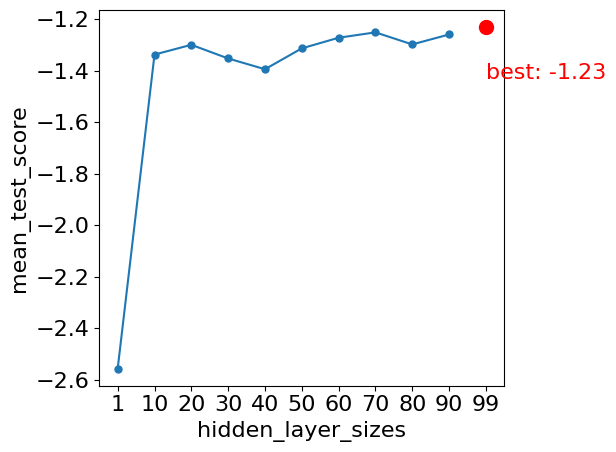

In [46]:
# plot the the mean_test_score against hidden_layer_sizes
import matplotlib.pyplot as plt
# sample 10 data points from the result, equally spaced
hidden_layer_sizes_sample = hidden_layer_sizes[::10]
mean_test_score_sample = mean_test_score[::10]
plt.plot(hidden_layer_sizes_sample, mean_test_score_sample, marker='o', markersize=5)

# mark the best hyperparameter with label
best_idx = mean_test_score[:100].idxmax()
plt.scatter(hidden_layer_sizes[best_idx], mean_test_score[best_idx], color='red')
# offset the text position
plt.text(hidden_layer_sizes[best_idx], mean_test_score[best_idx]-0.2, f'best: {mean_test_score[best_idx]:.2f}', color='red')
plt.xlabel('hidden_layer_sizes')
plt.ylabel('mean_test_score')
# compact graph
plt.tight_layout()
plt.show()

In [47]:
# 5-fold cross-validation with a MLPRegressor model
default_NN = SklearnModel(model='MLPRegressor', hidden_layer_sizes=99)
models = [default_NN]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']
processor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=2, n_splits=5)
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=processor,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

Running outer split: 100%|██████████| 1/1 [00:14<00:00, 14.16s/it]